<a href="https://colab.research.google.com/github/YTIputi/Nearest-Neighbor-Search-Methods/blob/main/NearestNeighborSearchMethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Requirements**

In [ ]:
pip install ydata_profiling annoy faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.1 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=09ac1bd155eac158397b3eae01b24923afac0ce00ac4367dfb96eb05fbe48d05
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=553316 sha256=

# **Nearest Neighbor Search Methods**

In this notebook I will introduce you to various methods of finding nearest neighbors. I will use a data set designed for income classification

---

### **Libraries**

In [ ]:
import kagglehub
import os
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import cosine_distances
from annoy import AnnoyIndex
import faiss
from sklearn.ensemble import IsolationForest

---

## **Dataset**

**Adult income dataset**

An individual’s annual income results from various factors. Intuitively, it is influenced by the individual’s education level, age, gender, occupation, and etc.

This is a widely cited KNN dataset. I encountered it during my course, and I wish to share it here because it is a good starter example for data pre-processing and machine learning practices.

**Fields**

The dataset contains 16 columns

*Target filed:*
Income
-- The income is divide into two classes: <=50K and >50K

*Number of attributes:* 14
-- These are the demographics and other features to describe a person

In [ ]:
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")
os.listdir(path)

['adult.csv']

In [ ]:
data = pd.read_csv(os.path.join(path, os.listdir(path)[0]))
new_data = data.copy()

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


---

## **Profiling**

In [ ]:
profile = ProfileReport(new_data, title="Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 15/15 [00:01<00:00, 13.18it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Data contains duplicates, missing values ​​in attributes: **workclass**, **occupation**, **native-country** (represented as "?"). Attributes: **fnlwgt**, **hours-per-week** have outliers, **capital-gain**, **capital-loss** consist of almost 0. The **target** attribute is not balanced.

---

## **Preprocessing**

### **Remove duplicates**

In [ ]:
new_data = new_data.drop_duplicates().reset_index(drop=True)
new_data

age     workclass  fnlwgt     education  educational-num  \
0       25       Private  226802          11th                7   
1       38       Private   89814       HS-grad                9   
2       28     Local-gov  336951    Assoc-acdm               12   
3       44       Private  160323  Some-college               10   
4       18             ?  103497  Some-college               10   
...    ...           ...     ...           ...              ...   
48785   27       Private  257302    Assoc-acdm               12   
48786   40       Private  154374       HS-grad                9   
48787   58       Private  151910       HS-grad                9   
48788   22       Private  201490       HS-grad                9   
48789   52  Self-emp-inc  287927       HS-grad                9   

           marital-status         occupation relationship   race  gender  \
0           Never-married  Machine-op-inspct    Own-child  Black    Male   
1      Married-civ-spouse    Farming-fishing      Husband  White    Male   
2      Married-civ-spouse    Protective-serv      Husband  White    Male   
3      Married-civ-spouse  Machine-op-inspct      Husband  Black    Male   
4           Never-married                  ?    Own-child  White  Female   
...                   ...                ...          ...    ...     ...   
48785  Married-civ-spouse       Tech-support         Wife  White  Female   
48786  Married-civ-spouse  Machine-op-inspct      Husband  White    Male   
48787             Widowed       Adm-clerical    Unmarried  White  Female   
48788       Never-married       Adm-clerical    Own-child  White    Male   
48789  Married-civ-spouse    Exec-managerial         Wife  White  Female   

       capital-gain  capital-loss  hours-per-week native-country income  
0                 0             0              40  United-States  <=50K  
1                 0             0              50  United-States  <=50K  
2                 0             0              40  United-States   >50K  
3              7688             0              40  United-States   >50K  
4                 0             0              30  United-States  <=50K  
...             ...           ...             ...            ...    ...  
48785             0             0              38  United-States  <=50K  
48786             0             0              40  United-States   >50K  
48787             0             0              40  United-States  <=50K  
48788             0             0              20  United-States  <=50K  
48789         15024             0              40  United-States   >50K  

[48790 rows x 15 columns]

### **Handling missing values**

I will remove the **workclass** column since most of the data is sensitive.

In [ ]:
new_data.drop(['workclass'], axis=1, inplace=True)
new_data

age  fnlwgt     education  educational-num      marital-status  \
0       25  226802          11th                7       Never-married   
1       38   89814       HS-grad                9  Married-civ-spouse   
2       28  336951    Assoc-acdm               12  Married-civ-spouse   
3       44  160323  Some-college               10  Married-civ-spouse   
4       18  103497  Some-college               10       Never-married   
...    ...     ...           ...              ...                 ...   
48785   27  257302    Assoc-acdm               12  Married-civ-spouse   
48786   40  154374       HS-grad                9  Married-civ-spouse   
48787   58  151910       HS-grad                9             Widowed   
48788   22  201490       HS-grad                9       Never-married   
48789   52  287927       HS-grad                9  Married-civ-spouse   

              occupation relationship   race  gender  capital-gain  \
0      Machine-op-inspct    Own-child  Black    Male             0   
1        Farming-fishing      Husband  White    Male             0   
2        Protective-serv      Husband  White    Male             0   
3      Machine-op-inspct      Husband  Black    Male          7688   
4                      ?    Own-child  White  Female             0   
...                  ...          ...    ...     ...           ...   
48785       Tech-support         Wife  White  Female             0   
48786  Machine-op-inspct      Husband  White    Male             0   
48787       Adm-clerical    Unmarried  White  Female             0   
48788       Adm-clerical    Own-child  White    Male             0   
48789    Exec-managerial         Wife  White  Female         15024   

       capital-loss  hours-per-week native-country income  
0                 0              40  United-States  <=50K  
1                 0              50  United-States  <=50K  
2                 0              40  United-States   >50K  
3                 0              40  United-States   >50K  
4                 0              30  United-States  <=50K  
...             ...             ...            ...    ...  
48785             0              38  United-States  <=50K  
48786             0              40  United-States   >50K  
48787             0              40  United-States  <=50K  
48788             0              20  United-States  <=50K  
48789             0              40  United-States   >50K  

[48790 rows x 14 columns]

I'll process the remaining columns.

In [ ]:
new_data.replace('?', np.nan, inplace=True)

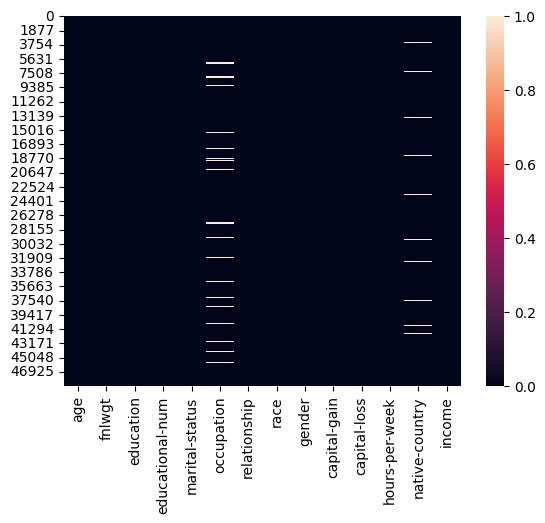

In [ ]:
sns.heatmap(new_data.isna());

In [ ]:
new_data.isna().sum(axis=0) / new_data.shape[0] * 100

age                0.000000
fnlwgt             0.000000
education          0.000000
educational-num    0.000000
marital-status     0.000000
occupation         5.749129
relationship       0.000000
race               0.000000
gender             0.000000
capital-gain       0.000000
capital-loss       0.000000
hours-per-week     0.000000
native-country     1.754458
income             0.000000
dtype: float64

There are not many missing values, so I remove them.

In [ ]:
new_data = new_data.dropna().reset_index(drop=True)
new_data

age  fnlwgt     education  educational-num      marital-status  \
0       25  226802          11th                7       Never-married   
1       38   89814       HS-grad                9  Married-civ-spouse   
2       28  336951    Assoc-acdm               12  Married-civ-spouse   
3       44  160323  Some-college               10  Married-civ-spouse   
4       34  198693          10th                6       Never-married   
...    ...     ...           ...              ...                 ...   
45170   27  257302    Assoc-acdm               12  Married-civ-spouse   
45171   40  154374       HS-grad                9  Married-civ-spouse   
45172   58  151910       HS-grad                9             Widowed   
45173   22  201490       HS-grad                9       Never-married   
45174   52  287927       HS-grad                9  Married-civ-spouse   

              occupation   relationship   race  gender  capital-gain  \
0      Machine-op-inspct      Own-child  Black    Male             0   
1        Farming-fishing        Husband  White    Male             0   
2        Protective-serv        Husband  White    Male             0   
3      Machine-op-inspct        Husband  Black    Male          7688   
4          Other-service  Not-in-family  White    Male             0   
...                  ...            ...    ...     ...           ...   
45170       Tech-support           Wife  White  Female             0   
45171  Machine-op-inspct        Husband  White    Male             0   
45172       Adm-clerical      Unmarried  White  Female             0   
45173       Adm-clerical      Own-child  White    Male             0   
45174    Exec-managerial           Wife  White  Female         15024   

       capital-loss  hours-per-week native-country income  
0                 0              40  United-States  <=50K  
1                 0              50  United-States  <=50K  
2                 0              40  United-States   >50K  
3                 0              40  United-States   >50K  
4                 0              30  United-States  <=50K  
...             ...             ...            ...    ...  
45170             0              38  United-States  <=50K  
45171             0              40  United-States   >50K  
45172             0              40  United-States  <=50K  
45173             0              20  United-States  <=50K  
45174             0              40  United-States   >50K  

[45175 rows x 14 columns]

### **Processing continuous features**

I will remove the **capital-gain**, **capital-loss** columns as they are not informative.

In [ ]:
new_data.drop(['capital-gain', 'capital-loss'], axis=1, inplace=True)
new_data

age  fnlwgt     education  educational-num      marital-status  \
0       25  226802          11th                7       Never-married   
1       38   89814       HS-grad                9  Married-civ-spouse   
2       28  336951    Assoc-acdm               12  Married-civ-spouse   
3       44  160323  Some-college               10  Married-civ-spouse   
4       34  198693          10th                6       Never-married   
...    ...     ...           ...              ...                 ...   
45170   27  257302    Assoc-acdm               12  Married-civ-spouse   
45171   40  154374       HS-grad                9  Married-civ-spouse   
45172   58  151910       HS-grad                9             Widowed   
45173   22  201490       HS-grad                9       Never-married   
45174   52  287927       HS-grad                9  Married-civ-spouse   

              occupation   relationship   race  gender  hours-per-week  \
0      Machine-op-inspct      Own-child  Black    Male              40   
1        Farming-fishing        Husband  White    Male              50   
2        Protective-serv        Husband  White    Male              40   
3      Machine-op-inspct        Husband  Black    Male              40   
4          Other-service  Not-in-family  White    Male              30   
...                  ...            ...    ...     ...             ...   
45170       Tech-support           Wife  White  Female              38   
45171  Machine-op-inspct        Husband  White    Male              40   
45172       Adm-clerical      Unmarried  White  Female              40   
45173       Adm-clerical      Own-child  White    Male              20   
45174    Exec-managerial           Wife  White  Female              40   

      native-country income  
0      United-States  <=50K  
1      United-States  <=50K  
2      United-States   >50K  
3      United-States   >50K  
4      United-States  <=50K  
...              ...    ...  
45170  United-States  <=50K  
45171  United-States   >50K  
45172  United-States  <=50K  
45173  United-States  <=50K  
45174  United-States   >50K  

[45175 rows x 12 columns]

Attributes **fnlwgt**, **hours-per-week** have outliers. I will provide a **violinplot**

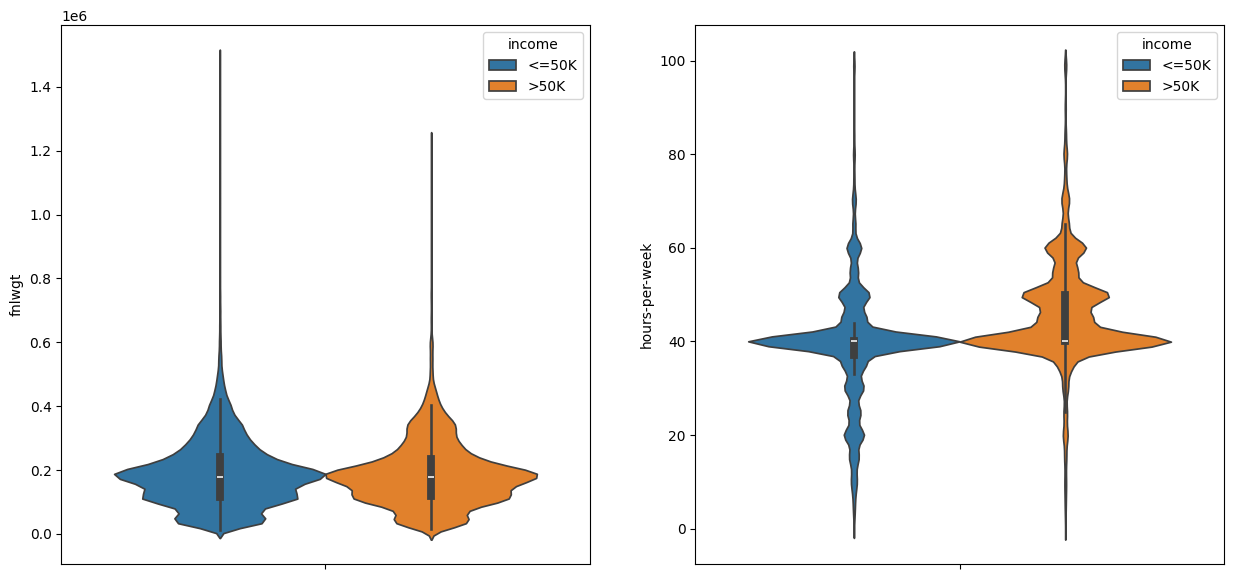

In [ ]:
fig, axe = plt.subplots(1, 2, figsize=(15, 7))

sns.violinplot(data=new_data, y='fnlwgt', hue='income', ax=axe[0])
sns.violinplot(data=new_data, y='hours-per-week', hue='income', ax=axe[1]);

I use **IsolationForest** to remove outliers

In [ ]:
clf = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
clf.fit(new_data[['fnlwgt', 'hours-per-week']])

IsolationForest(contamination=0.05, random_state=42)

In [ ]:
data_predict = new_data[clf.predict(new_data[['fnlwgt', 'hours-per-week']]) == 1]

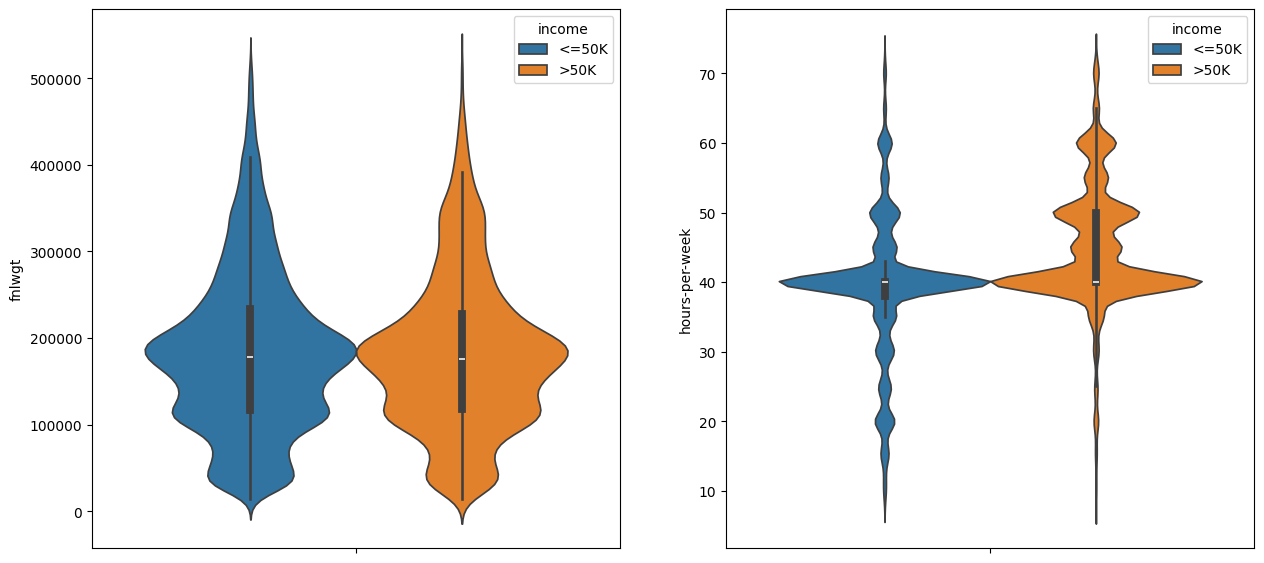

In [ ]:
fig, axe = plt.subplots(1, 2, figsize=(15, 7))

sns.violinplot(data=data_predict, y='fnlwgt', hue='income', ax=axe[0])
sns.violinplot(data=data_predict, y='hours-per-week', hue='income', ax=axe[1]);

The data has become cleaner

In [ ]:
new_data = data_predict
new_data

age  fnlwgt     education  educational-num      marital-status  \
0       25  226802          11th                7       Never-married   
1       38   89814       HS-grad                9  Married-civ-spouse   
2       28  336951    Assoc-acdm               12  Married-civ-spouse   
3       44  160323  Some-college               10  Married-civ-spouse   
4       34  198693          10th                6       Never-married   
...    ...     ...           ...              ...                 ...   
45170   27  257302    Assoc-acdm               12  Married-civ-spouse   
45171   40  154374       HS-grad                9  Married-civ-spouse   
45172   58  151910       HS-grad                9             Widowed   
45173   22  201490       HS-grad                9       Never-married   
45174   52  287927       HS-grad                9  Married-civ-spouse   

              occupation   relationship   race  gender  hours-per-week  \
0      Machine-op-inspct      Own-child  Black    Male              40   
1        Farming-fishing        Husband  White    Male              50   
2        Protective-serv        Husband  White    Male              40   
3      Machine-op-inspct        Husband  Black    Male              40   
4          Other-service  Not-in-family  White    Male              30   
...                  ...            ...    ...     ...             ...   
45170       Tech-support           Wife  White  Female              38   
45171  Machine-op-inspct        Husband  White    Male              40   
45172       Adm-clerical      Unmarried  White  Female              40   
45173       Adm-clerical      Own-child  White    Male              20   
45174    Exec-managerial           Wife  White  Female              40   

      native-country income  
0      United-States  <=50K  
1      United-States  <=50K  
2      United-States   >50K  
3      United-States   >50K  
4      United-States  <=50K  
...              ...    ...  
45170  United-States  <=50K  
45171  United-States   >50K  
45172  United-States  <=50K  
45173  United-States  <=50K  
45174  United-States   >50K  

[42916 rows x 12 columns]

### **Normalize the data**

In [ ]:
categorical_features, number_features = new_data.select_dtypes(exclude='number').columns, new_data.select_dtypes(include='number').columns
categorical_features.shape, number_features.shape

((8,), (4,))

In [ ]:
column_trans = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), number_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features.drop('income'))]
)

In [ ]:
target = LabelEncoder().fit_transform(new_data['income'])
target

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
X, y = new_data.drop(['income'], axis=1), target
X.shape, y.shape

((42916, 11), (42916,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, train_size=.8, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34332, 11), (8584, 11), (34332,), (8584,))

In [ ]:
X_train = column_trans.fit_transform(X_train)
X_test = column_trans.transform(X_test)
X_train.shape, X_test.shape

((34332, 88), (8584, 88))

## **Methods**

There are many algorithms for finding nearest neighbors. They are divided into **exact** and **approximate**. I will give examples of each type

---

I would like to use cosine similarity to find nearest neighbors. However, many algorithms do not include this distance in their implementation. To achieve the desired results, you need to normalize the data

$$
x' = \frac{x}{\|x\|}
$$

and use the Euclidean

$$
\| x' - y' \|^2 = 2 (1 - \cos \theta)
$$

In [ ]:
def normalize_vectors(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / norms

In [ ]:
X_train = normalize_vectors(X_train).astype('float32')

In [ ]:
X_train.dtype

dtype('float32')

Let's choose a random vector to compare the results of the algorithms

In [ ]:
random_index = np.random.choice(X_train.shape[0])
query = X_train[random_index].reshape(1, -1)

### **Exact**

#### **Brute-force search**

In [ ]:
def k_nearest_neighbors(data, query, k):
    distances = cosine_distances(data, query).reshape(-1)
    indices = np.argsort(distances)[:k]
    return distances[indices], indices

In [ ]:
distances, indices = k_nearest_neighbors(X_train, query, k=5)
distances, indices

(array([0.00000000e+00, 6.56133008e-05, 8.72073732e-05, 9.60829253e-05,
        2.46809498e-04]),
 array([25424,  2768,  6021, 12592, 12604]))

#### **KDTree**

It is best to use kd-tree for data that satisfies the condition

$$
N \gg 2^{D}
$$

In my case, the intrinsic (or effective) dimensionality is 4, while the total dimensionality is 88. This is because I have only 4 real-valued features, and the rest are binary (one-hot encoded) attributes

$$
2^{D} = 2^{4} = 16
$$

In [ ]:
kdt_tree = KDTree(X_train, leaf_size=30, metric='euclidean')

In [ ]:
distances, indices = kdt_tree.query(query, k=5)
distances, indices

(array([[2.71444296e-08, 1.14554179e-02, 1.32066174e-02, 1.38623898e-02,
         2.22175381e-02]]),
 array([[25424,  2768,  6021, 12592, 12604]]))

### **Approximate**

#### **Annoy**

Although it is an approximate algorithm, it has demonstrated good accuracy

In [ ]:
annoy_index = AnnoyIndex(88, 'angular')

for i, vec in enumerate(X_train):
    annoy_index.add_item(i, vec)

annoy_index.build(10)

True

In [ ]:
neighbors = annoy_index.get_nns_by_vector(query.flatten(), 5, include_distances=True)
neighbors

([25424, 2768, 6021, 12592, 12604],
 [0.0,
  0.011456414125859737,
  0.013201666064560413,
  0.013858072459697723,
  0.022215455770492554])

#### **Locality-sensitive hashing (LSH)**

In my case, this algorithm produces the worst results when finding similar neighbors

In [ ]:
index = faiss.IndexLSH(88, 352)
index.add(X_train)

In [ ]:
distances, indices = index.search(query, 5)
distances, indices

(array([[0., 3., 5., 5., 5.]], dtype=float32),
 array([[25424,  6021, 10260, 21372, 28298]]))

#### **Proximity graphs & Hierarchical navigable small world (HNSW)**

This algorithm is considered one of the best for finding nearest neighbors. It provides very accurate results on my data



In [ ]:
index = faiss.IndexHNSWFlat(88, 32, faiss.METRIC_INNER_PRODUCT)
index.hnsw.efConstruction = 200
index.hnsw.efSearch = 50
index.add(X_train)

In [ ]:
distances, indices = index.search(query, 5)
distances, indices

(array([[1.        , 0.9999344 , 0.9999128 , 0.999904  , 0.99975324]],
       dtype=float32),
 array([[25424,  2768,  6021, 12592, 12604]]))

---

## **Summary**

I will provide the execution time for each approach

**Brute-force search**

In [ ]:
%%timeit
random_index = np.random.choice(X_train.shape[0])
query = X_train[random_index].reshape(1, -1)
distances, indices = k_nearest_neighbors(X_train, query, k=5)

39.6 ms ± 9.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**KDTree**

In [ ]:
%%timeit
random_index = np.random.choice(X_train.shape[0])
query = X_train[random_index].reshape(1, -1)
distances, indices = kdt_tree.query(query, k=5)

3.13 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Annoy**

In [ ]:
%%timeit
random_index = np.random.choice(X_train.shape[0])
query = X_train[random_index]
neighbors = annoy_index.get_nns_by_vector(query, 5, include_distances=True)

64.7 µs ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Locality-sensitive hashing (LSH)**

In [ ]:
%%timeit
random_index = np.random.choice(X_train.shape[0])
query = X_train[random_index].reshape(1, -1)
distances, indices = index.search(query, 5)

110 µs ± 51.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Proximity graphs & Hierarchical navigable small world (HNSW)**

In [ ]:
%%timeit
random_index = np.random.choice(X_train.shape[0])
query = X_train[random_index].reshape(1, -1)
distances, indices = index.search(query, 5)

71.5 µs ± 8.17 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
